In [339]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
# from DYNASMART_Process import *
from Modules import DYNASMART_Process as dy
# import preprocessing_read_skim_file as rs
from Modules import AV_functions as av
from Modules import Solve_DARP as sod
from Modules import Postprocess_DARP as pod
from Modules import Preprocess_DARP as prd
from Modules import DARP_to_DYNA as dtd
from gurobipy import *
from Modules import *
import datetime
import requests
import math
import importlib
import random
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [341]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
personData=pd.read_csv('input/personData_1.csv')
person_type_dic=dict(zip(personData.person_id,personData.type))
traveler_trips=pd.read_csv('input/traveler_trip_info_improved.csv',index_col=0)
num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
superzone_filepath='Input/SuperZone.dat'
linktraveltime_filepath='Input/output_td_linktraveltime.dat'
superzone_map=dy.read_superzone_info(superzone_filepath)
origin_path='Input/origin.dat'
destination_path='Input/destination.dat'
origins,destinations,origin_links=dy.read_origin_destion(origin_path,destination_path)
origin_links['length']=origin_links.apply(lambda row: 
                                          link_detail[int(link_id[node_id[row.u_node],node_id[row.d_node]])][0,4],axis=1)
VPNRSkim_folder_filepath='Input/vehicularPNRSkim'
Vehicular_Skim,Vehicular_Skim_Dict=dy.read_vehicle_skim(VPNRSkim_folder_filepath)
transit_skim_folderpath='Input/'
TransitMazTazFlag,drivingweight,walkingweight,\
TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,\
Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk=dy.read_transitskim(transit_skim_folderpath)
Transit_AB_Cost_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Cost_Skim,TransitSkimTimeIntervalLength)
Transit_AB_Time_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Time_Skim,TransitSkimTimeIntervalLength)
transit_zone_dict={}
for link_zone in three_link_walk.three_link_zone.unique():
    transit_zone_dict[link_zone]=list(three_link_walk[three_link_walk.three_link_zone==link_zone]['transit_zone'].astype(int))
three_link_walk_dict={}
for index,group in three_link_walk.groupby(['three_link_zone']):
    three_link_walk_dict[index]={}
    for inx,row in group.iterrows():
        three_link_walk_dict[index][row.transit_zone]=row.distance
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
drivingcost_per_mile=0.5
intrasuperzone_info,intrasuperzone_path_dic=dtd.read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)
traveler_trips=prd.compare_mode_utlity(traveler_trips,TransitMazTazFlag,
                        three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
                        Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
                        Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)

56 57 72


In [342]:
car_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>=1)]
car_trips=car_trips.loc[(car_trips.orig_taz !=car_trips.dest_taz) | (car_trips.trip_counter==1)]
car_transit_trips=car_trips.append(traveler_trips[traveler_trips.tripmode>8])
# car_transit_trips=prd.compare_mode_utlity(car_transit_trips,TransitMazTazFlag,
#                         three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
#                         Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
#                         Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)
random.seed(100)
car_transit_trips_sample=car_transit_trips[car_transit_trips.hh_id.isin(random.sample(list(car_transit_trips.hh_id.unique()),3000))]
car_trips_sample=car_trips[car_trips.hh_id.isin(random.sample(list(car_transit_trips.hh_id.unique()),3000))]

In [316]:
car_transit_trips_sample.car_utility=car_transit_trips_sample.apply(lambda row: 
        (prd.estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time*0.0,
        Vehicular_Skim_Dict,0,superzone_map,drivingcost_per_mile)), axis=1)
car_transit_trips_sample['predicted_mode']=car_transit_trips_sample.apply(lambda row:
        'NonCar' if row.transit_utility<row.car_utility else 'Car',axis=1)

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [244]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
# target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
# target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
# target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
# target_trips.value_of_time=target_trips.value_of_time*0.8
# car_transit_trips_sample.value_of_time=car_transit_trips_sample.value_of_time*0.7
# for share_ride_factor in [1,1.25,1.5]:
print('********************************')
print(share_ride_factor)
# target_trips=car_trips_sample[car_trips_sample.hh_id==1486727]

route_info_modechoice,darp_solutions_modechoice=\
bsod.get_route_info_allhh(car_transit_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )
output_filepath='Output/AllHH/'
dtd.save_run_result('MO/',route_info_modechoice,darp_solutions_modechoice,output_filepath)
# pod.analysis_network_level_results(route_info,darp_solutions,car_trips_sample,
#                                    Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

********************************
1.5
Estimate Route for the  0 th household  2018-07-18 16:59:29.499307
Estimate Route for the  1000 th household  2018-07-18 17:12:34.755412
Estimate Route for the  2000 th household  2018-07-18 17:26:20.331311
Estimate Route for the  3000 th household  2018-07-18 17:42:36.361520
Estimate Route for the  4000 th household  2018-07-18 17:55:20.704049
Estimate Route for the  5000 th household  2018-07-18 18:05:54.989238
Estimate Route for the  6000 th household  2018-07-18 18:15:23.216393
Estimate Route for the  7000 th household  2018-07-18 18:25:45.629890
Estimate Route for the  8000 th household  2018-07-18 18:35:53.389913
Estimate Route for the  9000 th household  2018-07-18 18:45:02.511539
Estimate Route for the  10000 th household  2018-07-18 18:54:07.769634
Estimate Route for the  11000 th household  2018-07-18 19:03:15.186383
Estimate Route for the  12000 th household  2018-07-18 19:12:31.852060
Estimate Route for the  13000 th household  2018-07-1

NameError: name 'route_info_mo' is not defined

In [245]:
output_filepath='Output/AllHH/'
dtd.save_run_result('MO/',route_info_modechoice,darp_solutions_modechoice,output_filepath)

In [247]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
# target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
# target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
# target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
# target_trips.value_of_time=target_trips.value_of_time*0.8
# car_transit_trips_sample.value_of_time=car_transit_trips_sample.value_of_time*0.7
# for share_ride_factor in [1,1.25,1.5]:
print('********************************')
print(share_ride_factor)
# target_trips=car_trips_sample[car_trips_sample.hh_id==1486727]
car_transit_trip_07vot=car_transit_trips.copy()
car_transit_trip_07vot.value_of_time=car_transit_trip_07vot.value_of_time*0.7
route_info_modechoice07vot,darp_solutions_modechoice07vot=\
sod.get_route_info_allhh(car_transit_trip_07vot,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )
output_filepath='Output/AllHH/'
dtd.save_run_result('MO07vot/',route_info_modechoice07vot,darp_solutions_modechoice07vot,output_filepath)

# pod.analysis_network_level_results(route_info,darp_solutions,car_trips_sample,
#                                    Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

********************************
1.5
Estimate Route for the  0 th household  2018-07-19 06:40:34.474386
Estimate Route for the  1000 th household  2018-07-19 06:52:51.166434
Estimate Route for the  2000 th household  2018-07-19 07:05:24.917075
Estimate Route for the  3000 th household  2018-07-19 07:19:34.272205
Estimate Route for the  4000 th household  2018-07-19 07:31:00.229322
Estimate Route for the  5000 th household  2018-07-19 07:41:26.836525
Estimate Route for the  6000 th household  2018-07-19 07:50:11.262119
Estimate Route for the  7000 th household  2018-07-19 08:00:14.068038
Estimate Route for the  8000 th household  2018-07-19 08:09:45.963410
Estimate Route for the  9000 th household  2018-07-19 08:18:33.922419
Estimate Route for the  10000 th household  2018-07-19 08:27:15.391969
Estimate Route for the  11000 th household  2018-07-19 08:35:43.590920
Estimate Route for the  12000 th household  2018-07-19 08:44:29.074603
Estimate Route for the  13000 th household  2018-07-1

In [366]:
route_info_2avoption,darp_solutions2avoption,hh_car_list=pod.determin_number_car(darp_solutions15,darp_solutions2av,
                    route_info15,route_info2va,30,car_trips_sample)

2744264
3416215
1845629
2566260
3863435
1667634
2034509
1312563
1113661
2566352
2980369
241400
3467877
1845573
1114005
3044861
3155650
2104131
2238690
2237496
1309942
867859
2105230
1839465
1401828
2287281
1120697
1667491
1309667
2175474
644489
2105101
1401853
2238891
1265896
1400559
1309889
2285746
2212491
1437235
1309567
3044765
3440685
1972521
2212539
1400639
152683
2287260
2830031
1119532
409255
1845701
832021
1486727
409871
1120023
1486380
1042126
2238845
2101474
1114070
3223958
724444
2238885
3307979
1738173
2175316
2175270
1972445
2831346
2237242
1113411
2567115
2212082
1312585
3044632
2980168
3440775
2101367
2067032
644625
1266613
3044504
3066920
1265857
3132935
2101407
1972683
3418755
2104145
1120606
2211965
2104401
647135
2035794
1975029
937979
1486465
3157532
2238465
1667430
1309638
1839487
2101486
2101661
2034449
3461981
1588492
3401939
1972862
1486859
2238483
1401704
1945247
1113652
763717
2034416
1840639
644753
3155667
2238848
867868
2104463
1120157
3308790
2035801
328142

3458802
2566984
2825740
1486885
3409481
2571960
1490200
3025664
2831009
72617
364714
1118998
2983197
1844330
2983605
3469875
1113620
2101657
972034
1973053
1840736
1119492
2573596
3580099
1738005
2211900
2175272
1839620
1113513
644527
2035371
1844413
1844868
2105100
3580160
647359
1839517
1840341
2388968
2825813
1437288
3474655
725197
3440789
3069906
3282354
3326527
867865
3091850
1786303
1438139
2921362
2831057
3044570
1843919
1843973
2176814
2067577
3450435
1119512
2573391
2573591
1845600
2566142
1113809
644551
72772
2825764
3359049
72815
1489781
1257296
1845080
971959
483981
1113845
1113869
2980354
1114099
2825604
1114381
3307990
1667640
2830305
1669018
1975336
2566056
1437074
1667470
1840047
2566865
1114334
2034472
2982965
2829986
1844857
242320
647206
1401838
2831256
647371
3440864
563876
2566264
2285493
2175386
1840035
1486667
1786268
2980741
3132081
2825788
1486894
152597
2572267
3450437
2067705
1438351
1028171
3308800
1839434
2980180
1400515
644435
3337720
1486487
2566457
11137

In [248]:
average_value_of_time=round(car_trips.value_of_time.mean(),4)
for external_factor in [30,40,50]:
    dtd.write_darp_solution_to_file('MO07vot/',output_filepath,route_info_modechoice07vot,darp_solutions_modechoice07vot,origin_links,
        superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)
    dtd.write_darp_solution_to_file('MO/',output_filepath,route_info_modechoice,darp_solutions_modechoice,origin_links,
        superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)
#     dtd.write_darp_solution_to_file('CA15/',output_filepath,route_info_ca15,darp_solutions_ca15,origin_links,
#         superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)

2018-07-19 13:57:00.835109
2018-07-19 13:57:43.918843
10000 2018-07-19 13:58:48.255822
30000 2018-07-19 14:00:27.349458
40000 2018-07-19 14:01:12.135002
50000 2018-07-19 14:02:14.122526
60000 2018-07-19 14:03:10.051706
70000 2018-07-19 14:03:30.685880
80000 2018-07-19 14:03:54.474237
90000 2018-07-19 14:04:31.316326
100000 2018-07-19 14:05:07.947408
110000 2018-07-19 14:05:49.202757
120000 2018-07-19 14:06:10.122943
140000 2018-07-19 14:07:03.531981
150000 2018-07-19 14:07:30.096489
160000 2018-07-19 14:08:01.892297
170000 2018-07-19 14:08:32.942063
180000 2018-07-19 14:09:06.130950
190000 2018-07-19 14:09:42.002988
200000 2018-07-19 14:10:18.126043
2018-07-19 14:10:33.845937
2018-07-19 14:11:15.136285
20000 2018-07-19 14:12:25.143263
30000 2018-07-19 14:13:06.770631
40000 2018-07-19 14:14:02.264785
50000 2018-07-19 14:14:45.846268
60000 2018-07-19 14:15:27.401625
70000 2018-07-19 14:15:50.170920
80000 2018-07-19 14:16:20.133624
90000 2018-07-19 14:16:59.947887
100000 2018-07-19 14:17:

In [251]:
pod.analysis_network_level_results(route_info_modechoice,darp_solutions_modechoice,car_transit_trips,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

Number of AV Trips: 	 231697
Number of Shared Rides: 	 3281.0
Total VMT: 	 1665283.395999958
Number of occupied trips: 	 182473
Number of unoccupied trips: 	 49224
Number of transit trips: 	 13011.0
total_convention_vehicle_driving_time: 	 13194.786666664204
total_convention_vehicle_driving_distance: 	 1351117.135999888
total_AV_driving_time: 	 15962.67833333344
total_AV_unoccupied_driving_time: 	 3142.688333333233
total_AV_driving_distance: 	 1665842.013999959
total_AV_unoccupied_driving_distance: 	 334629.6349999963
Number of pickup trips: 	 179178.0


In [252]:
pod.analysis_network_level_results(route_info_modechoice07vot,darp_solutions_modechoice07vot,car_transit_trips,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

Number of AV Trips: 	 232405
Number of Shared Rides: 	 3053.0
Total VMT: 	 1671813.256999961
Number of occupied trips: 	 182816
Number of unoccupied trips: 	 49589
Number of transit trips: 	 12443.0
total_convention_vehicle_driving_time: 	 13194.786666664204
total_convention_vehicle_driving_distance: 	 1351117.135999888
total_AV_driving_time: 	 16030.25333333336
total_AV_unoccupied_driving_time: 	 3156.2033333332442
total_AV_driving_distance: 	 1672348.4359999613
total_AV_unoccupied_driving_distance: 	 336406.75299999537
Number of pickup trips: 	 179746.0


In [237]:
output_filepath='Output/3000SampleHH/'
dtd.save_run_result('MV2option/',route_info_2avoption,darp_solutions2avoption,output_filepath)


In [198]:
pod.analysis_network_level_results(route_info_2avoption,darp_solutions2avoption,car_trips_sample,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

Number of AV Trips: 	 22262
Number of Shared Rides: 	 317.0
Total VMT: 	 162213.32200000455
Number of occupied trips: 	 18044
Number of unoccupied trips: 	 4218
Number of transit trips: 	 0.0
total_convention_vehicle_driving_time: 	 1310.4933333333283
total_convention_vehicle_driving_distance: 	 133666.38099999996
total_AV_driving_time: 	 1563.466666666677
total_AV_unoccupied_driving_time: 	 265.24333333333254
total_AV_driving_distance: 	 162229.25300000454
total_AV_unoccupied_driving_distance: 	 28434.717999999888
Number of pickup trips: 	 17727.0


In [166]:
pod.analysis_network_level_results(route_info15,darp_solutions15,car_trips_sample,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

Number of AV Trips: 	 22544
Number of Shared Rides: 	 327
Total VMT: 	 164440.83500000494
Number of occupied trips: 	 18054
Number of unoccupied trips: 	 4490
Number of transit trips: 	 0
total_convention_vehicle_driving_time: 	 1310.4933333333283
total_convention_vehicle_driving_distance: 	 133666.38099999996
total_AV_driving_time: 	 1585.196666666684
total_AV_unoccupied_driving_time: 	 286.83833333333297
total_AV_driving_distance: 	 164437.4640000048
total_AV_unoccupied_driving_distance: 	 30597.37699999986
Number of pickup trips: 	 17727


In [167]:
pod.analysis_network_level_results(route_info125,darp_solutions125,car_trips_sample,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

Number of AV Trips: 	 22545
Number of Shared Rides: 	 160
Total VMT: 	 165421.28700000534
Number of occupied trips: 	 17887
Number of unoccupied trips: 	 4658
Number of transit trips: 	 0
total_convention_vehicle_driving_time: 	 1310.4933333333283
total_convention_vehicle_driving_distance: 	 133666.38099999996
total_AV_driving_time: 	 1598.4633333333506
total_AV_unoccupied_driving_time: 	 298.04666666666617
total_AV_driving_distance: 	 165415.2230000052
total_AV_unoccupied_driving_distance: 	 31763.401999999864
Number of pickup trips: 	 17727


In [168]:
pod.analysis_network_level_results(route_info1,darp_solutions1,car_trips_sample,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

Number of AV Trips: 	 22524
Number of Shared Rides: 	 0
Total VMT: 	 166272.4850000058
Number of occupied trips: 	 17727
Number of unoccupied trips: 	 4797
Number of transit trips: 	 0
total_convention_vehicle_driving_time: 	 1310.4933333333283
total_convention_vehicle_driving_distance: 	 133666.38099999996
total_AV_driving_time: 	 1611.8316666666835
total_AV_unoccupied_driving_time: 	 305.7849999999991
total_AV_driving_distance: 	 166272.55500000567
total_AV_unoccupied_driving_distance: 	 32606.173999999843
Number of pickup trips: 	 17727


In [50]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
# target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
# target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
# target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
# target_trips.value_of_time=target_trips.value_of_time*0.8
# car_transit_trips_sample.value_of_time=car_transit_trips_sample.value_of_time*0.7
# for share_ride_factor in [1,1.25,1.5]:
print('********************************')
print(share_ride_factor)
route_infomodechoice,darp_solutionsmodechoice=\
sod.get_route_info_allhh(car_transit_trips_sample,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )



********************************
1.5
Estimate Route for the  0 th household  2018-07-17 20:35:09.885699
Estimate Route for the  100 th household  2018-07-17 20:36:14.097354
Estimate Route for the  200 th household  2018-07-17 20:37:19.342058
Estimate Route for the  300 th household  2018-07-17 20:38:25.071795
Estimate Route for the  400 th household  2018-07-17 20:39:28.883425
Estimate Route for the  500 th household  2018-07-17 20:40:19.255286
Estimate Route for the  600 th household  2018-07-17 20:41:13.022447
Estimate Route for the  700 th household  2018-07-17 20:41:55.376132
Estimate Route for the  800 th household  2018-07-17 20:42:44.050220
Estimate Route for the  900 th household  2018-07-17 20:43:26.872935
Estimate Route for the  1000 th household  2018-07-17 20:44:05.224370
Estimate Route for the  1100 th household  2018-07-17 20:44:42.103702
Estimate Route for the  1200 th household  2018-07-17 20:45:29.148685
Estimate Route for the  1300 th household  2018-07-17 20:46:07.97

In [59]:
pod.analysis_network_level_results(route_infomodechoice,darp_solutionsmodechoice,car_transit_trips_sample,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

Number of AV Trips 22404
Number of Shared Rides 310.0
Total VMT 162222.538000003
Number of occupied trips   18081
Number of unoccupied trips  4323
Number of transit trips 1291.0
total_convention_vehicle_driving_time 1311.3933333333218
total_convention_vehicle_driving_distance 134187.67900000012
total_AV_driving_time 1559.418333333341
total_AV_unoccupied_driving_time 286.98333333333375
total_AV_driving_distance 162270.12600000302
total_AV_unoccupied_driving_distance 30273.89699999995


In [619]:
darp_solutions_ca15=pod.load_obj('darp_solutions','Output/AllHH/CA15/')

In [633]:
potential_hh=[]
for hh_id,group in car_trips.groupby('hh_id'):
    if darp_solutions_ca15[hh_id]['num_pickup_trips']-darp_solutions_modechoice[hh_id]['num_pickup_trips']>0\
    and (darp_solutions_ca15[hh_id]['num_pickup_trips']-darp_solutions_modechoice[hh_id]['num_pickup_trips']<3):
        if darp_solutions_ca15[hh_id]['num_shared_trips']>2:
            if darp_solutions_ca15[hh_id]['num_cav_trips'] >15:
                if len(group.person_id.unique())>2:
                    print(hh_id,len(group),len(car_transit_trips[car_transit_trips.hh_id==hh_id]),
                          darp_solutions_modechoice[hh_id]['num_pickup_trips'],darp_solutions_ca15[hh_id]['num_pickup_trips'])
                    potential_hh.extend([hh_id])

409230 22 22 21 22
1486572 18 18 17 18
1972428 19 19 18 19
2034250 19 19 18 19
2034295 20 20 18 20
2175294 24 24 22 24
2175411 22 22 20 22
2177257 10 10 9 10
2177266 12 12 11 12
2238733 21 25 19 21
2285480 20 20 19 20
2285535 16 16 15 16
2285539 25 25 24 25
2287028 19 19 17 19
2287487 23 23 22 23
3132925 31 31 29 31
3474720 14 14 13 14


C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


25
num_cav_trips 31
num_occupied_trips 21
num_unoccupied_trips 10
num_pickup_trips 19
num_shared_trips 2
num_convention car trips 21
total_convention_vehicle_driving_time 2.145
total_AV_driving_time 2.338333333333333
total_AV_unoccupied_driving_time 0.7133333333333333
total_convention_vehicle_driving_distance 82.03799999999998
total_AV_driving_distance 88.72500000000001
total_AV_unoccupied_driving_distance 26.402
total_reward 14908.270852293203
total_schedule_penalty 1.1440000000000055
total_travel_cost 141.99196
reward_mode 1
drivingcost_per_mile 0.5
share_ride_factor 1.5
run_mode 0
num_cav 1
cav_use_mode 0
time_window_flag 0


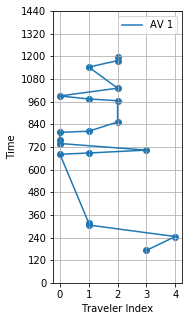

In [635]:
target_hh_id=2238733 
pod.analysis_one_hh_result_new_darpsolution(target_hh_id,darp_solutions_modechoice,car_transit_trips,num_cav,
    Vehicular_Skim_Dict,superzone_map)

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


21
num_cav_trips 34
num_occupied_trips 25
num_unoccupied_trips 9
num_pickup_trips 21
num_shared_trips 4
num_convention car trips 21
total_convention_vehicle_driving_time 2.145
total_AV_driving_time 2.891666666666666
total_AV_unoccupied_driving_time 0.7266666666666667
total_convention_vehicle_driving_distance 82.03799999999998
total_AV_driving_distance 109.4595
total_AV_unoccupied_driving_distance 27.372
total_reward 3150.0
total_schedule_penalty 5.14850000000016
total_travel_cost 177.00476
reward_mode 2
drivingcost_per_mile 0.5
share_ride_factor 1.5
run_mode 0
num_cav 1
cav_use_mode 0
time_window_flag 0


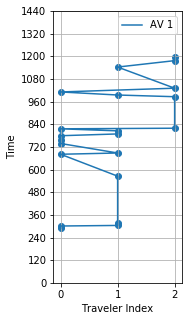

In [661]:
pod.analysis_one_hh_result_new_darpsolution(target_hh_id,darp_solutions_ca15,car_trips,num_cav,
    Vehicular_Skim_Dict,superzone_map)

In [652]:
car_transit_trips_double_transit=car_transit_trips.copy()
car_transit_trips_double_transit.transit_utility=car_transit_trips_double_transit.transit_utility*1.3

In [653]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
# target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
# target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
# target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
# target_trips.value_of_time=target_trips.value_of_time*0.8
# car_transit_trips_sample.value_of_time=car_transit_trips_sample.value_of_time*0.7
# for share_ride_factor in [1,1.25,1.5]:
print('********************************')
print(share_ride_factor)
route_infomodechoice_double_utility,darp_solutionsmodechoice_double_utility=\
sod.get_route_info_allhh(car_transit_trips_double_transit[car_transit_trips_double_transit.hh_id==target_hh_id],
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )



********************************
1.5
Estimate Route for the  0 th household  2018-07-25 21:29:16.179771


In [655]:
darp_solutionsmodechoice_double_utility[target_hh_id]

{'cav_use_mode': 0,
 'drivingcost_per_mile': 0.5,
 'hh_id': 2238733,
 'hh_num_trips': 25,
 'num_cav': 1,
 'num_cav_trips': 36,
 'num_convention car trips': 21,
 'num_occupied_trips': 24,
 'num_pickup_trips': 22,
 'num_shared_trips': 2,
 'num_unoccupied_trips': 12,
 'objective_value': 19255.205048375323,
 'reward_mode': 1,
 'route_info':     orig_zone  dest_zone  orig_node_index  dest_node_index  person_id  \
 0          18         18                1               26    7657710   
 1          18         18               26                2          0   
 2          18         17                2               27    7657711   
 3          17         18               27                5          0   
 4          18         20                5               30    7657708   
 6          20         18                6               31    7657708   
 0          18         14                7               32    7657708   
 1          14         14               32                8          0

In [662]:
len(car_transit_trips[car_transit_trips.hh_id==target_hh_id])

25

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


25
num_cav_trips 36
num_occupied_trips 24
num_unoccupied_trips 12
num_pickup_trips 22
num_shared_trips 2
num_convention car trips 21
total_convention_vehicle_driving_time 2.145
total_AV_driving_time 2.8133333333333335
total_AV_unoccupied_driving_time 0.825
total_convention_vehicle_driving_distance 82.03799999999998
total_AV_driving_distance 106.08900000000001
total_AV_unoccupied_driving_distance 30.311
total_reward 19338.55633837532
total_schedule_penalty 1.799000000000003
total_travel_cost 81.55228999999999
reward_mode 1
drivingcost_per_mile 0.5
share_ride_factor 1.5
run_mode 0
num_cav 1
cav_use_mode 0
time_window_flag 0


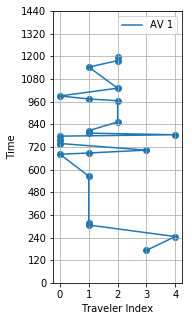

In [654]:
target_hh_id=2238733
pod.analysis_one_hh_result_new_darpsolution(target_hh_id,darp_solutionsmodechoice_double_utility,car_transit_trips_double_transit,num_cav,
    Vehicular_Skim_Dict,superzone_map)

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


26
num_cav_trips 29
num_occupied_trips 23
num_unoccupied_trips 6
num_pickup_trips 22
num_shared_trips 1
num_convention car trips 21
total_convention_vehicle_driving_time 1.5116666666666665
total_AV_driving_time 1.7699999999999998
total_AV_unoccupied_driving_time 0.33666666666666667
total_convention_vehicle_driving_distance 59.531000000000006
total_AV_driving_distance 68.102
total_AV_unoccupied_driving_distance 13.4475
total_reward 15450.869542468408
total_schedule_penalty 0.8859999999999932
total_travel_cost 123.0495
reward_mode 1
drivingcost_per_mile 0.5
share_ride_factor 1.5
run_mode 0
num_cav 1
cav_use_mode 0
time_window_flag 0


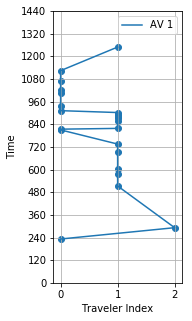

In [615]:
pod.analysis_one_hh_result_new_darpsolution(target_hh_id,darp_solutions_modechoice07vot,car_transit_trips,num_cav,
    Vehicular_Skim_Dict,superzone_map)

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


21
num_cav_trips 27
num_occupied_trips 22
num_unoccupied_trips 5
num_pickup_trips 21
num_shared_trips 1
num_convention car trips 21
total_convention_vehicle_driving_time 1.5216666666666667
total_AV_driving_time 1.6266666666666671
total_AV_unoccupied_driving_time 0.10166666666666666
total_convention_vehicle_driving_distance 56.964
total_AV_driving_distance 60.36450000000001
total_AV_unoccupied_driving_distance 3.500000000000001
total_reward 19118.86664624838
total_schedule_penalty 0.3120000000000004
total_travel_cost 112.43656000000003
reward_mode 1
drivingcost_per_mile 0.5
share_ride_factor 1.5
run_mode 0
num_cav 1
cav_use_mode 0
time_window_flag 0


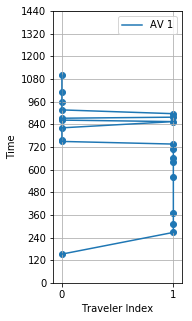

In [563]:
target_hh_id=2066778
pod.analysis_one_hh_result_new_darpsolution(target_hh_id,darp_solutions_modechoice,car_transit_trips,num_cav,
    Vehicular_Skim_Dict,superzone_map)

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\alex\Autonomous-V-demand\Modules\Postprocess_DARP.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

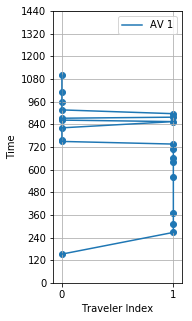

In [436]:
target_hh_id=2066778 
pod.plot_route_info_schedule(route_info_modechoice[route_info_modechoice.hh_id==target_hh_id],
                             car_transit_trips[car_transit_trips.hh_id==target_hh_id],num_cav)


In [ ]:
route_inf

In [ ]:
drivingcost_per_mile=0.5

In [ ]:
modechoice_target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
modechoice_target_trips=modechoice_target_trips[(modechoice_target_trips.orig_taz!=modechoice_target_trips.dest_taz) | (modechoice_target_trips.trip_counter==1)]
modechoice_target_trips=modechoice_target_trips.append(traveler_trips[traveler_trips.tripmode>8])

In [ ]:
modechoice_target_trips=prd.compare_mode_utlity(modechoice_target_trips,TransitMazTazFlag,
                                               three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
                                               Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
                                               Vehicular_Skim_Dict1,superzone_map,drivingcost_per_mile,transit_zone_dict)

In [ ]:
modechoice_target_trips.value_of_time=modechoice_target_trips.value_of_time*0.8

In [ ]:
modechoice_target_trips['car_utility']=modechoice_target_trips.apply(lambda row: 
        (prd.estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,
        Vehicular_Skim_Dict,0,superzone_map,drivingcost_per_mile)), axis=1)
    
modechoice_target_trips['predicted_mode']=modechoice_target_trips.apply(lambda row:
    'NonCar' if row.transit_utility<row.car_utility else 'Car',axis=1)

In [ ]:
modechoice_target_trips.groupby(['predicted_mode']).count()

In [ ]:
run_name='allhhcartrip1.5/'
output_filepath='Output/'+run_name
route_info_allcar=pd.read_csv(output_filepath+'route_info.csv')
darp_solution=pod.load_obj('darp_solutions',output_filepath)
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
external_factor='50'
dtd.write_darp_solution_to_file(run_name,output_filepath,route_info_allcar,darp_solution,origin_links,
    superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)

In [ ]:
run_name='allhhcartrip1.5/'
output_filepath='Output/'+run_name
route_info_allcar15=pd.read_csv(output_filepath+'route_info.csv')
darp_solution_callcar15=pod.load_obj('darp_solutions',output_filepath)
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
external_factor='50'
dtd.write_darp_solution_to_file(run_name,output_filepath,route_info_allcar15,darp_solution_callcar15,origin_links,
    superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)

In [ ]:
run_name='allhhcartrip1.25/'
output_filepath='Output/'+run_name
route_info_allcar125=pd.read_csv(output_filepath+'route_info.csv')
darp_solution_allcar125=pod.load_obj('darp_solutions',output_filepath)
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
external_factor='50'
dtd.write_darp_solution_to_file(run_name,output_filepath,route_info_allcar,darp_solution_allcar125,origin_links,
    superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)

In [ ]:
run_name='modechoice1.1/'
output_filepath='Output/'+run_name
route_info_modechoice10=pd.read_csv(output_filepath+'route_info.csv')
darp_solution_modechoice10=pod.load_obj('darp_solutions',output_filepath)
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
output_filepath=output_filepath
external_factor='40'
dtd.write_darp_solution_to_file(run_name,output_filepath,route_info_modechoice10,darp_solution_modechoice10,origin_links,
    superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)

# dtd.route_to_vehiclepathdat(route_info_modechoice10,origin_links,output_filepath,
#                             vehicle_filepath,path_filepath,superzone_map,
#                                 intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time)

In [ ]:
community_solution_allcar15=pod.load_obj('community_allcar15','Output/')

In [ ]:
community_solution_allcar15

In [ ]:
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>6])
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
community_hh_list=[972044,972024,2212041,2212030,937968,2285653,1309779,1738127,2034377,2066988]
community_trips=pd.DataFrame()
for hh_id in community_hh_list:
#     print(len(target_trips[target_trips.hh_id==hh_id]))
    community_trips=community_trips.append(target_trips[target_trips.hh_id==hh_id])
sorted_trips=community_trips.sort_values('starttime')
pod.analysis_one_hh_result(937968,[community_solution_allcar15],community_trips,5,Vehicular_Skim_Dict,superzone_map)

In [ ]:
pod.plot_route_info_schedule(community_solution_allcar15['route_info'],community_trips,5)